<a href="https://colab.research.google.com/github/HSE-LAMBDA/MLDM-2022/blob/main/13-GANs/GAN_HW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### WGAN

* Modify snippets below and implement [Wasserstein GAN](https://arxiv.org/abs/1701.07875) with weight clipping. (2 points)

* Replace  weight clipping with [gradient penalty](https://arxiv.org/pdf/1704.00028v3.pdf). (2 points)

* Add labels into WGAN, performing [conditional generation](https://arxiv.org/pdf/1411.1784.pdf). (2 points) 

Write a report about experiments and results, add plots and visualizations.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import torchvision
import matplotlib.pyplot as plt
import numpy as np

from torch.autograd import Variable

### Creating config object (argparse workaround)

In [2]:
class Config:
    pass

config = Config()
config.mnist_path = None
config.batch_size = 16
config.num_workers = 3
config.num_epochs = 10
config.noise_size = 50
config.print_freq = 100


### Create dataloder

In [3]:
train = torchvision.datasets.FashionMNIST("fashion_mnist", train=True, transform=torchvision.transforms.ToTensor(), download=True)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting fashion_mnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to fashion_mnist/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting fashion_mnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to fashion_mnist/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting fashion_mnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to fashion_mnist/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting fashion_mnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to fashion_mnist/FashionMNIST/raw



In [4]:
dataloader = DataLoader(train, batch_size=16, shuffle=True)

In [5]:
len(dataloader)

3750

In [6]:
for image, cat in dataloader:
    break

In [7]:
image.size()

torch.Size([16, 1, 28, 28])

### Create generator and discriminator

In [8]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential( 
            nn.Linear(config.noise_size, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 28*28),
            nn.Sigmoid())
        
    def forward(self, x):
        return self.model(x)
    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 1), 
            nn.Sigmoid())
    def forward(self, x):
        return self.model(x)

In [9]:
generator = Generator()
discriminator = Discriminator()

### Create optimizers and loss

In [10]:
# modification2: use RMSprop (or SGD) instead of Adam
# optimizer
# optim_G = optim.Adam(params=generator.parameters(), lr=0.0001)
# optim_D = optim.Adam(params=discriminator.parameters(), lr=0.0001)
optim_G = optim.RMSprop(params=generator.parameters(),lr=0.00005)
optim_D = optim.RMSprop(params=discriminator.parameters(),lr=0.00005)

# modification4: no log in loss
# criterion = nn.BCELoss()

### Create necessary variables

In [11]:
from torch.utils.tensorboard import SummaryWriter
input = Variable(torch.FloatTensor(config.batch_size, 28*28))
noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size))
fixed_noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size).normal_(0, 1))
label = Variable(torch.FloatTensor(config.batch_size))
real_label = 1
fake_label = 0

# for tensorboard plotting
writer_real = SummaryWriter(f"logs/real")
writer_fake = SummaryWriter(f"logs/fake")
step = 0

generator.train()
discriminator.train()

Discriminator(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=200, out_features=50, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=50, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

### GAN

In [12]:
ERRD_x = np.zeros(config.num_epochs)
ERRD_z = np.zeros(config.num_epochs)
ERRG = np.zeros(config.num_epochs)
N = len(dataloader)
#WGAN modified of DCGAN in:
#1. remove sigmoid in the last layer of discriminator(classification -> regression)
#2. no log Loss (Wasserstein distance)
#3. clip param norm to c (Wasserstein distance and Lipschitz continuity)
#4. No momentum-based optimizer, use RMSProp，SGD instead

for epoch in range(config.num_epochs):
    for iteration, (images, cat) in enumerate(dataloader):
        # Train Critic: max E[critic(real)] - E[critic(fake)]
        # CRITIC_ITERATIONS = 5
        # optim_D.zero_grad()
        ####### 
        # Discriminator stage: maximize log(D(x)) + log(1 - D(G(z))) 
        #######
        discriminator.zero_grad()
        # real
        label.data.fill_(real_label)
        input_data = images.view(images.shape[0], -1)
        output_real = discriminator(input_data)
        # errD_x = criterion(output, label)
        # ERRD_x[epoch] += errD_x.item()
        # errD_x.backward()
        
        # fake 
        noise.data.normal_(0, 1)
        fake = generator(noise)
        label.data.fill_(fake_label)
        output_fake = discriminator(fake.detach())
        # errD_z = criterion(output, label)
        # ERRD_z[epoch] += errD_z.item()
        # errD_z.backward()
        loss_critic = -(torch.mean(output_real) - torch.mean(output_fake))


        loss_critic.backward(retain_graph=True)
        optim_D.step()
        
        # modification3: clip param norm to c=0.01 (Wasserstein distance and Lipschitz continuity)
        for parm in discriminator.parameters():
            parm.data.clamp_(-0.01, 0.01)


        # Train Generator: max E[critic(gen_fake)] <-> min -E[critic(gen_fake)]
        generator.zero_grad()
        label.data.fill_(real_label)
        gen_fake = discriminator(fake)
        loss_gen = -torch.mean(gen_fake)

        loss_gen.backward()

        optim_G.step()

        ####### 
        # Generator stage: maximize log(D(G(x))
        #######
        # generator.zero_grad()
        # label.data.fill_(real_label)
        # output = discriminator(fake)
        # errG = criterion(output, label)
        # ERRG[epoch] += errG.item()
        # errG.backward()
        
        # optim_G.step()
        
        '''
        if (iteration+1) % config.print_freq == 0:
            print('Epoch:{} Iter: {} errD_x: {:.2f} errD_z: {:.2f} errG: {:.2f}'.format(epoch+1,
                                                                                            iteration+1, 
        '''
        
        # Print losses occasionally and print to tensorboard
        if iteration % 100 == 0 and iteration > 0:
            generator.eval()
            discriminator.eval()
            print(
                f"Epoch [{epoch+1}/{10}] Batch {iteration}/{len(dataloader)} \
                  Loss D: {loss_critic:.4f}, loss G: {loss_gen:.4f}"
            )

            with torch.no_grad():
                fake = generator(noise)
                # take out (up to) 32 examples
                img_grid_real = torchvision.utils.make_grid(
                    images[:32], normalize=True
                )
                img_grid_fake = torchvision.utils.make_grid(
                    fake[:32], normalize=True
                )

                writer_real.add_image("Real", img_grid_real, global_step=step)
                writer_fake.add_image("Fake", img_grid_fake, global_step=step)

            step += 1
            generator.train()
            discriminator.train()


Epoch [1/10] Batch 100/3750                   Loss D: -0.0229, loss G: -0.4882
Epoch [1/10] Batch 200/3750                   Loss D: -0.0356, loss G: -0.4740
Epoch [1/10] Batch 300/3750                   Loss D: -0.0353, loss G: -0.4621
Epoch [1/10] Batch 400/3750                   Loss D: -0.0285, loss G: -0.4560
Epoch [1/10] Batch 500/3750                   Loss D: -0.0326, loss G: -0.4509
Epoch [1/10] Batch 600/3750                   Loss D: -0.0302, loss G: -0.4530
Epoch [1/10] Batch 700/3750                   Loss D: -0.0251, loss G: -0.4669
Epoch [1/10] Batch 800/3750                   Loss D: -0.0194, loss G: -0.4841
Epoch [1/10] Batch 900/3750                   Loss D: -0.0180, loss G: -0.4940
Epoch [1/10] Batch 1000/3750                   Loss D: -0.0293, loss G: -0.4924
Epoch [1/10] Batch 1100/3750                   Loss D: -0.0286, loss G: -0.4947
Epoch [1/10] Batch 1200/3750                   Loss D: -0.0306, loss G: -0.4999
Epoch [1/10] Batch 1300/3750                   Lo

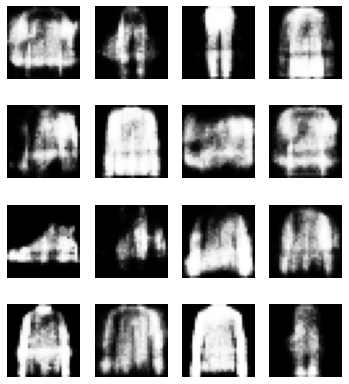

In [13]:
noise.data.normal_(0, 1)
fake = generator(noise)

plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake[i].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')

In [14]:
def gradient_penalty(critic, real, fake):
    real = real.view(16, 784)
    alpha = torch.rand((16, 784))
    interpolated_images = real * alpha + fake * (1 - alpha)

    # Calculate critic scores
    mixed_scores = critic(interpolated_images)

    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty

In [15]:
# switch algorighm back to Adam
optimD = optim.Adam(discriminator.parameters(), lr=1e-4, betas=(0.5, 0.9))
optimG = optim.Adam(generator.parameters(), lr=1e-4, betas=(0.5, 0.9))

In [16]:
for epoch in range(config.num_epochs):
    for iteration, (images, cat) in enumerate(dataloader):
        # real
        label.data.fill_(real_label)
        input_data = images.view(images.shape[0], -1)
        output_real = discriminator(input_data)
        # errD_x = criterion(output, label)
        # ERRD_x[epoch] += errD_x.item()
        # errD_x.backward()
        
        # fake 
        noise.data.normal_(0, 1)
        fake = generator(noise)
        label.data.fill_(fake_label)
        output_fake = discriminator(fake.detach())
        
        # add gp here
        gp = gradient_penalty(discriminator, images, fake)
        loss_critic = (
                -(torch.mean(output_real) - torch.mean(output_fake)) + 10 * gp # LAMBDA_GP = 10
            )
        discriminator.zero_grad()
        loss_critic.backward(retain_graph=True)
        optim_D.step()



        # Train Generator: max E[critic(gen_fake)] <-> min -E[critic(gen_fake)]
        generator.zero_grad()
        label.data.fill_(real_label)
        gen_fake = discriminator(fake)
        loss_gen = -torch.mean(gen_fake)

        loss_gen.backward()

        optim_G.step()
        ####### 
        # Generator stage: maximize log(D(G(x))
        #######
        # generator.zero_grad()
        # label.data.fill_(real_label)
        # output = discriminator(fake)
        # errG = criterion(output, label)
        # ERRG[epoch] += errG.item()
        # errG.backward()
        
        # optim_G.step()
        '''
        if (iteration+1) % config.print_freq == 0:
            print('Epoch:{} Iter: {} errD_x: {:.2f} errD_z: {:.2f} errG: {:.2f}'.format(epoch+1,
                                                                                            iteration+1, 
        '''
        
        # Print losses occasionally and print to tensorboard
        if iteration % 100 == 0 and iteration > 0:
            generator.eval()
            discriminator.eval()
            print(
                f"Epoch [{epoch+1}/{10}] Batch {iteration}/{len(dataloader)} \
                  Loss D: {loss_critic:.4f}, loss G: {loss_gen:.4f}"
            )

            with torch.no_grad():
                fake = generator(noise)
                # take out (up to) 32 examples
                img_grid_real = torchvision.utils.make_grid(
                    images[:32], normalize=True
                )
                img_grid_fake = torchvision.utils.make_grid(
                    fake[:32], normalize=True
                )

                writer_real.add_image("Real", img_grid_real, global_step=step)
                writer_fake.add_image("Fake", img_grid_fake, global_step=step)

            step += 1
            generator.train()
            discriminator.train()

Epoch [1/10] Batch 100/3750                   Loss D: 8.9805, loss G: -0.5894
Epoch [1/10] Batch 200/3750                   Loss D: 9.2363, loss G: -0.5446
Epoch [1/10] Batch 300/3750                   Loss D: 9.8855, loss G: -0.4985
Epoch [1/10] Batch 400/3750                   Loss D: 10.0112, loss G: -0.4965
Epoch [1/10] Batch 500/3750                   Loss D: 10.0004, loss G: -0.4967
Epoch [1/10] Batch 600/3750                   Loss D: 10.0002, loss G: -0.4964
Epoch [1/10] Batch 700/3750                   Loss D: 10.0006, loss G: -0.4968
Epoch [1/10] Batch 800/3750                   Loss D: 10.0011, loss G: -0.4964
Epoch [1/10] Batch 900/3750                   Loss D: 10.0000, loss G: -0.4964
Epoch [1/10] Batch 1000/3750                   Loss D: 10.0000, loss G: -0.4964
Epoch [1/10] Batch 1100/3750                   Loss D: 10.0000, loss G: -0.4964
Epoch [1/10] Batch 1200/3750                   Loss D: 10.0000, loss G: -0.4964
Epoch [1/10] Batch 1300/3750                   Loss 

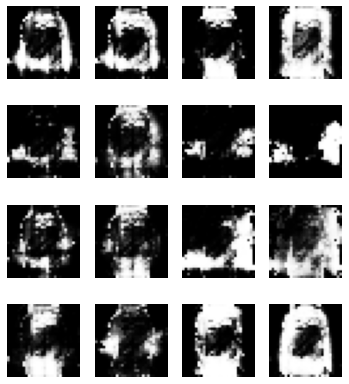

In [17]:
noise.data.normal_(0, 1)
fake = generator(noise)

plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake[i].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')

In [18]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential( 
            nn.Linear(config.noise_size+10, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 28*28),
            nn.Sigmoid())
        self.label_emb = nn.Embedding(10, 10)

    def forward(self, x, labels):
        x = x.view(x.size(0), 50)
        gen_input = torch.cat((x, self.label_emb(labels)), 1)
        img = self.model(gen_input)
        
        return img.view(x.size(0), 28, 28)
    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28+10, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 1), 
            nn.Sigmoid())
        self.label_emb = nn.Embedding(10, 10)
        
    def forward(self, x, labels):
        #print(x.size())
        d_in = torch.cat((x.view(x.size(0), -1), self.label_emb(labels)), -1)
        validity = self.model(d_in)
        return validity

In [19]:
generator = Generator()
discriminator = Discriminator()

optim_G = optim.Adam(params=generator.parameters(), lr=0.0001)
optim_D = optim.Adam(params=discriminator.parameters(), lr=0.0001)

criterion = nn.BCELoss()

In [20]:
noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size))
fixed_noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size).normal_(0, 1))
label = Variable(torch.FloatTensor(config.batch_size))

In [21]:
ERRD_x = np.zeros(config.num_epochs)
ERRD_z = np.zeros(config.num_epochs)
ERRG = np.zeros(config.num_epochs)
N = len(dataloader)

for epoch in range(config.num_epochs):
    for iteration, (images, cat) in enumerate(dataloader):
        ####### 
        # Discriminator stage: maximize log(D(x)) + log(1 - D(G(z))) 
        #######
        discriminator.zero_grad()
        
        # real
        label.data.fill_(real_label)
        input_data = images.view(images.shape[0], -1)
        output = discriminator(input_data, cat)
        errD_x = criterion(output.view(16), label)
        ERRD_x[epoch] += errD_x.item()
        errD_x.backward()
        
        # fake 
        noise.data.normal_(0, 1)
        fake = generator(noise, cat)
        label.data.fill_(fake_label)
        output = discriminator(fake.detach(), cat).view(16)
        errD_z = criterion(output, label)
        ERRD_z[epoch] += errD_z.item()
        errD_z.backward()
        
        optim_D.step()
        ####### 
        # Generator stage: maximize log(D(G(x))
        #######
        generator.zero_grad()
        label.data.fill_(real_label)
        output = discriminator(fake, cat).view(16)
        errG = criterion(output, label)
        ERRG[epoch] += errG.item()
        errG.backward()
        
        optim_G.step()
        
        if (iteration+1) % config.print_freq == 0:
            print('Epoch:{} Iter: {} errD_x: {:.2f} errD_z: {:.2f} errG: {:.2f}'.format(epoch+1,
                                                                                            iteration+1, 
                                                                                            errD_x.item(),
                                                                                            errD_z.item(), 
                                                                                            errG.item()))

Epoch:1 Iter: 100 errD_x: 0.16 errD_z: 0.13 errG: 2.16
Epoch:1 Iter: 200 errD_x: 0.24 errD_z: 0.27 errG: 2.17
Epoch:1 Iter: 300 errD_x: 0.30 errD_z: 0.15 errG: 2.16
Epoch:1 Iter: 400 errD_x: 0.06 errD_z: 0.13 errG: 2.24
Epoch:1 Iter: 500 errD_x: 0.16 errD_z: 0.10 errG: 2.50
Epoch:1 Iter: 600 errD_x: 0.08 errD_z: 0.10 errG: 2.41
Epoch:1 Iter: 700 errD_x: 0.10 errD_z: 0.15 errG: 2.24
Epoch:1 Iter: 800 errD_x: 0.11 errD_z: 0.13 errG: 2.42
Epoch:1 Iter: 900 errD_x: 0.18 errD_z: 0.14 errG: 2.24
Epoch:1 Iter: 1000 errD_x: 0.21 errD_z: 0.17 errG: 2.34
Epoch:1 Iter: 1100 errD_x: 0.23 errD_z: 0.17 errG: 2.54
Epoch:1 Iter: 1200 errD_x: 0.10 errD_z: 0.15 errG: 2.25
Epoch:1 Iter: 1300 errD_x: 0.10 errD_z: 0.11 errG: 3.08
Epoch:1 Iter: 1400 errD_x: 0.14 errD_z: 0.08 errG: 3.29
Epoch:1 Iter: 1500 errD_x: 0.10 errD_z: 0.13 errG: 3.01
Epoch:1 Iter: 1600 errD_x: 0.21 errD_z: 0.09 errG: 2.77
Epoch:1 Iter: 1700 errD_x: 0.23 errD_z: 0.14 errG: 3.32
Epoch:1 Iter: 1800 errD_x: 0.05 errD_z: 0.07 errG: 3.81
E

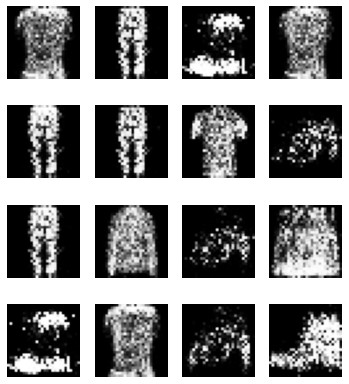

In [22]:
noise.data.normal_(0, 1)
fake = generator(noise, cat)

plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake[i].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')